# CNN - Exercise
In the tutorial Standing on the Shoulders of Giants you investigated a computer vision problem of your choice by applying transfer learning to a series of input images of your choice. For this exercise, you should re-use the weights for the convolutional layers and train the other layers of the model using your own input images and evaluate the results
Hand in your Jupyter notebook which also functions as a research report. You describe the context of the problem at hand, the methods, the results and your conclusion.

## Preparation
In this section useful libraries are imported which are used in most data science projects.

In [1]:
import os
import sys

# sets the path to the home directory of this repository so other modules can be imported. 
project_path = os.getcwd()
root_path = os.path.split(os.path.split(os.getcwd())[0])[0]
assert root_path.endswith("Fontys-ADS"), "The root path does not end with Fontys-ADS: " + root_path 
sys.path.insert(0, root_path)

import numpy as np
import tensorflow as tf

# set the seed for reproducible results.
np.random.seed(56)
tf.random.set_seed(56)

# optionally, set TensorFlow to use the GPU with all available memory.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Data collection
explain how to gather the data

In [2]:
import pandas as pd
import tensorflow_datasets as tfds
ds, info = tfds.load('cats_vs_dogs', split='train', with_info=True)
assert isinstance(ds, tf.data.Dataset)

In [3]:
# df = pd.DataFrame(tfds.as_numpy(ds))
# height, width, colors = df['image'].iloc[0].shape
# print(f'size: {len(df)}')
# print(f'height: {height}, width: {width}, colors: {colors}')

# Preparing the data
explain how the data is prepared

In [4]:
from datasets.base_image_dataset import ImageDatasetBase

# the dataset class
class CatsVsDogsDataset(ImageDatasetBase):
    def __init__(self, ds, batch_size, img_height, img_width, data_size, train_percentage, validation_percentage, test_percentage):
        super().__init__(batch_size, img_height, img_width)

        # sets the data.
        self.data = ds.map(self.process_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # shuffles the dataset
        self.shuffle(256)

        # splits the data into train, validation, and test datasets.
        self.split_data_to_train_val_test(self.data, train_percentage, validation_percentage, test_percentage, data_size / batch_size)

    def process_frame(self, ds):
        # convert image to 0..1
        img = tf.image.convert_image_dtype(ds['image'], tf.float32)

        # resize the image to the desired size.
        return tf.image.resize(img, [self.img_height, self.img_width]), ds['label']

In [5]:
data_size = 23262
img_height = 256
img_width = 256
img_channels = 3
classes = 2

batch_size = 64
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2
dataset = CatsVsDogsDataset(ds, batch_size, img_height, img_width, data_size, train_percentage, validation_percentage, test_percentage)

train: 218 validation: 72 test: 72


# Exploratory Data Analysis
Explore the data to gain insights on possible features

In [6]:
# fig = tfds.show_examples(ds, info)

64


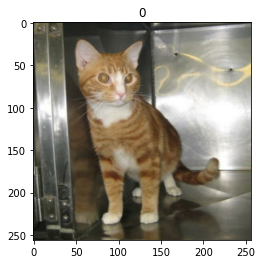

In [7]:
import matplotlib.pyplot as plt

for img, label in dataset.train_ds.take(1):
    print(len(img.numpy()))
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img[0])
    ax.set_title(label[0].numpy())

# Modelling
Apply ML/DL models

In [8]:
from models.base_model import ModelBase
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.activations import elu

class SuperCatDogClassifier(ModelBase):
    def __init__(self, img_height, img_width, img_channels, classes, gpu_initialized=False, training=False, limit=5000):
        super().__init__(gpu_initialized, training, limit)
        # the name for the model.
        self.name = 'SuperCatDogClassifier'

        # set img dimensions.
        self.img_height = img_height
        self.img_width = img_width
        self.img_channels = img_channels

        # set the classes.
        self.classes = classes

    def predict(self, X):
        # create predictable array, since predicting only works on an array.
        predictable_array = np.expand_dims(X, axis=0)

        # perform prediction and take the first and only prediction out of the predictions array.
        prediction = self.model.predict(X, verbose=1)[0]
        
        return prediction

    def fit(self, training, callbacks, epochs, validation, validation_steps, steps_per_epoch):
        self.model.fit(
            training,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=validation,
            validation_steps=validation_steps,
            steps_per_epoch=steps_per_epoch, verbose=1)

    def compile(self, optimizer='adam', loss='mse', metrics=['mse'], loss_weights=[1.0], show_summary=False):
        self.inputs = Input((self.img_height, self.img_width, self.img_channels))

        # the first layer in a U-Net architecture -> down sampling
        c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(self.inputs)
        p1 = MaxPooling2D((2, 2))(c1)

        c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
        p2 = MaxPooling2D((2, 2))(c9)

        c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
        p3 = MaxPooling2D((2, 2))(c2)

        f = Flatten()(p3)
        d1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(f)

        self.outputs = Dense(1, activation='sigmoid')(d1)

        # construct the model by stitching the inputs and outputs
        self.model = Model(inputs=self.inputs, outputs=self.outputs, name=self.name)

        # compile the model
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

        if show_summary:
            self.model.summary()

In [9]:
model = SuperCatDogClassifier(img_height, img_width, img_channels, classes, training=True, gpu_initialized=True)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime

epochs = 100
model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'], show_summary=True)

# current time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# create logging
log_dir = os.path.join(project_path, f'logs\{model.name}\{current_time}')

# create all callbacks
callbacks = [
  EarlyStopping(patience=50, monitor='val_loss'),
  TensorBoard(log_dir=log_dir, profile_batch=0)
]

Model: "SuperCatDogClassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 6

In [11]:
%load_ext tensorboard

In [12]:
# fit the model using the training data
results = model.fit(
  training=dataset.train_ds,
  callbacks=callbacks,
  epochs=epochs,
  validation=dataset.val_ds,
  validation_steps=dataset.val_size,
  steps_per_epoch=dataset.train_size)
  
# save the weights of the model
weights_path = os.path.join(project_path, f'models\{model.name}_trained_model_weights')
model.save_weights(weights_path)

Train for 218 steps, validate for 72 steps
Epoch 1/100
218/218 [==============================] - 42s 192ms/step - loss: 0.6527 - accuracy: 0.6373 - val_loss: 0.5538 - val_accuracy: 0.7266
Epoch 2/100
218/218 [==============================] - 19s 88ms/step - loss: 0.5307 - accuracy: 0.7385 - val_loss: 0.5020 - val_accuracy: 0.7593
Epoch 3/100
218/218 [==============================] - 19s 88ms/step - loss: 0.4632 - accuracy: 0.7838 - val_loss: 0.4744 - val_accuracy: 0.7732
Epoch 4/100
218/218 [==============================] - 21s 96ms/step - loss: 0.4186 - accuracy: 0.8102 - val_loss: 0.4582 - val_accuracy: 0.7843
Epoch 5/100
218/218 [==============================] - 22s 103ms/step - loss: 0.3828 - accuracy: 0.8339 - val_loss: 0.4508 - val_accuracy: 0.7912
Epoch 6/100
218/218 [==============================] - 22s 103ms/step - loss: 0.3530 - accuracy: 0.8506 - val_loss: 0.4505 - val_accuracy: 0.7884
Epoch 7/100
218/218 [==============================] - 22s 103ms/step - loss: 0.3309

# Validation
Validate the model performance

In [13]:
# re initialize the model.
model.training = False
model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'], show_summary=False) 
model.load_weights(weights_path)

print('\n# Evaluate on test data')
result = model.evaluate(dataset.actual_test_ds)
print('test loss, test acc:', result)
res = dict(zip(model.get_metric_names(), result))
print(res)

NameError: name 'weights_path' is not defined